# SAKI Exercise 1: Naive Bayes Classifier

Import relevant libraries.

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

Read the data set.

In [2]:
transactions = pd.read_csv("SAKI Exercise 1.csv", sep=";", index_col=0)
transactions

,Auftragskonto,Buchungstag,Valutadatum,Buchungstext,Verwendungszweck,Beguenstigter/Zahlungspflichtiger,Kontonummer,BLZ,Betrag,Waehrung,label
0,89990201.0,28.07.2016,28.07.2016,Lohn / Gehalt,Gehalt Adorsys GmbH & Co. KG End-To-End-Ref.: ...,Adorsys GmbH & Co. KG,7807800780,25190001,2000.00,EUR,income
1,89990201.0,27.07.2016,27.07.2016,Miete,Byladem1Sbt De12773501123456789889 Miete Beuth...,Georg Tasche,DE31251900019123456780,VOHADE2HXXX,-670.00,EUR,living
2,89990201.0,21.07.2016,21.07.2016,Bargeld,"21.07/16.34Uhr Nuernberg All Eur 70,00 Geb.Eur...",Bargeld,9999900780,25190001,-70.00,EUR,private
3,89990201.0,20.07.2016,20.07.2016,Lebensmittel / Getraenke,2831 Edeka Neubauer Nuernb.//Nuernb 2016-07-20...,Kartenzahlung,9736000780,25190001,-73.21,EUR,standardOfLiving
4,89990201.0,18.07.2016,18.07.2016,Spontanausgabe,Amazon,neue Playstation,9988776655,25125100,-363,EUR,leisure
...,...,...,...,...,...,...,...,...,...,...,...
204,NaN,15.02.2016,15.02.2016,Mieteinnahmen,Mietzuschuss End-To-End-Ref.: Notprovided Kund...,Isabel Anna,DE31251900019736000780,VOHADE2HXXX,200.00,EUR,finance
205,NaN,02.02.2016,02.02.2016,Geldanlage,Ccbade31Xxx De71310108339900123456 Sparen End-...,Michael Koffer,DE69790800529736000780,DRESDEFF790,-300.00,EUR,finance
206,NaN,28.01.2016,28.01.2016,Lohn / Gehalt,Gehalt Adorsys GmbH & Co. KG End-To-End-Ref.: ...,Adorsys GmbH & Co. KG,7807800780,25190001,2000.00,EUR,income
207,NaN,28.01.2016,28.01.2016,Geldanlage,Ssknde77Xxx De41760501010012345675 Einmalspare...,Christina Jung,DE31251900019736333780,VOHADE2HXXX,-4000.00,EUR,finance


Now, we remove all other features except for "Buchungstext", "Verwendungszweck" and "Beguenstigter/Zahlungspflichtiger". In addition, we merge those textual features into one string and perform some cleaning, such as the removal of punctuation.

In [3]:
data = pd.DataFrame({"X": transactions["Buchungstext"] + " " + transactions["Verwendungszweck"] + " " + transactions["Beguenstigter/Zahlungspflichtiger"], "y": transactions["label"]})

data["X"] = data["X"] \
  .str.replace(r'\S*\d{1,}\S*', "") \
  .str.replace(r'\S*[\.\&/]+\S*', "") \
  .str.replace(r'\b\w{1,3}\b', "") \
  .str.replace(":", "") \
  .str.replace("-", "") \
  .str.replace("(", "") \
  .str.replace(")", "") \
  .str.replace(",", "") \
  .str.replace("+", "") \
  .str.replace(r'\s{2,}', " ") \
  .str.strip()

Let's have a look at the distribution of the labels.

In [4]:
data["y"].value_counts()

leisure             65
standardOfLiving    47
finance             33
living              26
private             21
income              17
Name: y, dtype: int64

The data set seems to be imbalanced. We need to keep that in mind when evaluating the results. Now, let's perform a 70% training data and 30% test data split.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data["X"], data["y"], test_size=0.30)

We fit the CountVectorizer with the training data and transform the training and the test data.

In [10]:
count_vector = CountVectorizer(lowercase=True, strip_accents="ascii", ngram_range=(1, 2))

X_train_count = count_vector.fit_transform(X_train).toarray()
X_test_count = count_vector.transform(X_test).toarray()

Subsequently, we initialize the Multinomial Naive Bayes classifier and fit it to the training data.

In [11]:
mnb = MultinomialNB()
mnb.fit(X_train_count, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

We predict labels for the test data and evaluate the results using the confusion matrix and scikit's classification report.

In [12]:
y_pred = mnb.predict(X_test_count)

                  precision    recall  f1-score   support

         finance       1.00      0.88      0.93         8
          income       1.00      1.00      1.00         8
         leisure       0.86      0.96      0.91        25
          living       1.00      0.75      0.86         8
         private       0.80      1.00      0.89         4
standardOfLiving       0.89      0.80      0.84        10

        accuracy                           0.90        63
       macro avg       0.92      0.90      0.90        63
    weighted avg       0.91      0.90      0.90        63



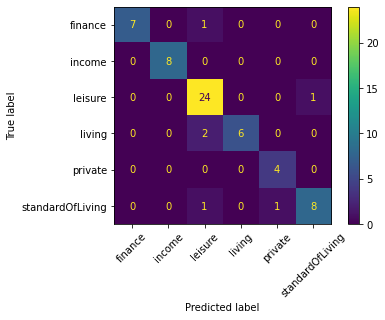

In [39]:
plot_confusion_matrix(mnb, X_test_count, y_test, xticks_rotation=45)
print(classification_report(y_test, y_pred))

To further evaluate our classifier, we initialize a pipeline with the CountVectorizer and the Multinomial Naive Bayes classifier. The FunctionTransformer is needed to make the sparse output of the CountVectorizer dense.

In [40]:
pipe = Pipeline([
    ('count', CountVectorizer(lowercase=True, strip_accents="unicode", ngram_range=(1, 2))),
    ("dense", FunctionTransformer(lambda x: x.todense(), accept_sparse=True)),
    ('multinomialNB', MultinomialNB()),
])

Next, we shuffle the data set and perform 5-fold cross-validation to ensure we have trained and tested on almost all data.

In [58]:
data_cv = data.sample(frac=1).reset_index(drop=True)
print(cross_validate(pipe, data_cv["X"], data_cv["y"], scoring="accuracy", cv=5)["test_score"])

[0.9047619  0.85714286 0.80952381 0.9047619  0.95121951]


All in all, our classifier still performs well. However, it is apparent that not all transactions work equally well.